# DSN Office Hour: Bootcamp Pre-Qulaification Hackathon CODE Bugs and Solutions

In [213]:
## Importing required libraries
import pandas as pd #for data preprocessing

#Data Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

#Linear Algebra
import numpy as np
 
#Import Datetime module
from datetime import datetime

from sklearn.model_selection import KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV, train_test_split #For splitting

#Evaluation Metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

#To ignore unnecessary warnings
import warnings

from sklearn.preprocessing import LabelEncoder,OneHotEncoder # for encoding categorical variables

In [214]:
!pip install catboost

In [215]:
import catboost as ctb
import lightgbm as ltb
from xgboost import XGBClassifier

In [277]:
#pass an argument when reading the data
#For Colab
path = '/content/drive/MyDrive/' #This is the path for of the folder where the datasets is stored in Drive
train = pd.read_csv('/content/drive/MyDrive/Train.csv', parse_dates=['Date_Customer'])
test = pd.read_csv('/content/drive/MyDrive/Test.csv', parse_dates=['Date_Customer'])
submission = pd.read_csv('/content/drive/MyDrive/SampleSubmission.csv')

In [278]:
#Method 2: Convert to Datetime later in your preprocessing steps
#Convert Datetime
train['Date_Customer'] = pd.to_datetime(train['Date_Customer']).apply(lambda x:x.value)
test['Date_Customer'] = pd.to_datetime(test['Date_Customer']).apply(lambda x:x.value)

In [279]:
#Drop ID from train and test
train.drop('ID', axis=1, inplace=True)
test.drop('ID', axis=1, inplace=True)

In [280]:
data = pd.concat([train, test], axis=0)
print(f'The combined dataset gives a shape of: {data.shape}')
data.head()

The combined dataset gives a shape of: (2240, 26)


,Year_of_Birth,Education_Level,Marital_Status,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Date_Customer,Recency,Discounted_Purchases,WebPurchases,CatalogPurchases,StorePurchases,Amount_on_Wines,Amount_on_Fruits,Amount_on_MeatProducts,Amount_on_FishProducts,Amount_on_SweetProducts,Amount_on_GoldProds,WebVisitsMonth,Cmp3Accepted,Cmp4Accepted,Cmp5Accepted,Cmp1Accepted,Cmp2Accepted,Any_Complain,Response
0,1955,Graduation,Divorced,77504.4,1,1,1403395200000000000,56,2,1,1,4,71,3,16,0,6,20,3,0,0,0,0,0,0,0.0
1,1958,Graduation,Together,56784.0,0,1,1357603200000000000,17,6,5,1,8,205,22,111,50,15,19,6,0,0,0,0,0,0,0.0
2,1962,Graduation,Single,103714.8,0,0,1384992000000000000,17,0,7,4,7,469,31,873,29,18,37,2,0,0,0,1,0,0,1.0
3,1979,2n Cycle,Single,46311.6,1,0,1379030400000000000,49,3,4,1,3,56,15,49,17,24,24,8,0,0,0,0,0,0,0.0
4,1959,Graduation,Married,87486.0,0,0,1390262400000000000,59,1,3,7,9,412,117,445,181,165,203,1,0,0,0,1,0,0,0.0


In [281]:
data.isnull().sum()

Year_of_Birth                0
Education_Level              0
Marital_Status               0
Disposable_Income           24
No_of_Kids_in_home           0
No_of_Teen_in_home           0
Date_Customer                0
Recency                      0
Discounted_Purchases         0
WebPurchases                 0
CatalogPurchases             0
StorePurchases               0
Amount_on_Wines              0
Amount_on_Fruits             0
Amount_on_MeatProducts       0
Amount_on_FishProducts       0
Amount_on_SweetProducts      0
Amount_on_GoldProds          0
WebVisitsMonth               0
Cmp3Accepted                 0
Cmp4Accepted                 0
Cmp5Accepted                 0
Cmp1Accepted                 0
Cmp2Accepted                 0
Any_Complain                 0
Response                   672
dtype: int64

In [282]:
#categ_cols == categorical columns . Date column excluded
categ_cols = train.select_dtypes(include=['object', 'category']).columns

# num column == numerical columns + date column included
num_cols = [col for col in train.columns if col not in categ_cols]
print(f'The Categorical Columns are: {categ_cols}')
print(f'The Numerical Columns are: {num_cols}')

The Categorical Columns are: Index(['Education_Level', 'Marital_Status'], dtype='object')
The Numerical Columns are: ['Year_of_Birth', 'Disposable_Income', 'No_of_Kids_in_home', 'No_of_Teen_in_home', 'Date_Customer', 'Recency', 'Discounted_Purchases', 'WebPurchases', 'CatalogPurchases', 'StorePurchases', 'Amount_on_Wines', 'Amount_on_Fruits', 'Amount_on_MeatProducts', 'Amount_on_FishProducts', 'Amount_on_SweetProducts', 'Amount_on_GoldProds', 'WebVisitsMonth', 'Cmp3Accepted', 'Cmp4Accepted', 'Cmp5Accepted', 'Cmp1Accepted', 'Cmp2Accepted', 'Any_Complain', 'Response']


In [283]:
for col in categ_cols:
    print(f'Unique entries in the {col} column in the test set is: {test[col].nunique()}')
    print(f'and the unique entries are: {test[col].unique()}')

Unique entries in the Education_Level column in the test set is: 5
and the unique entries are: ['Graduation' 'Basic' 'Master' '2n Cycle' 'PhD']
Unique entries in the Marital_Status column in the test set is: 6
and the unique entries are: ['Single' 'Widow' 'Married' 'Together' 'Divorced' 'Absurd']


In [284]:
train['Disposable_Income'].fillna((train['Disposable_Income'].mean()) , inplace = True)
#check again to make sure
train.isnull().sum()

Year_of_Birth              0
Education_Level            0
Marital_Status             0
Disposable_Income          0
No_of_Kids_in_home         0
No_of_Teen_in_home         0
Date_Customer              0
Recency                    0
Discounted_Purchases       0
WebPurchases               0
CatalogPurchases           0
StorePurchases             0
Amount_on_Wines            0
Amount_on_Fruits           0
Amount_on_MeatProducts     0
Amount_on_FishProducts     0
Amount_on_SweetProducts    0
Amount_on_GoldProds        0
WebVisitsMonth             0
Cmp3Accepted               0
Cmp4Accepted               0
Cmp5Accepted               0
Cmp1Accepted               0
Cmp2Accepted               0
Any_Complain               0
Response                   0
dtype: int64

In [285]:
# label encoding 
le = LabelEncoder()
for i in categ_cols:
  train[i] = le.fit_transform(train[i])
  test[i] = le.fit_transform(test[i])
train.head()

,Year_of_Birth,Education_Level,Marital_Status,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Date_Customer,Recency,Discounted_Purchases,WebPurchases,CatalogPurchases,StorePurchases,Amount_on_Wines,Amount_on_Fruits,Amount_on_MeatProducts,Amount_on_FishProducts,Amount_on_SweetProducts,Amount_on_GoldProds,WebVisitsMonth,Cmp3Accepted,Cmp4Accepted,Cmp5Accepted,Cmp1Accepted,Cmp2Accepted,Any_Complain,Response
0,1955,2,2,77504.4,1,1,1403395200000000000,56,2,1,1,4,71,3,16,0,6,20,3,0,0,0,0,0,0,0
1,1958,2,5,56784.0,0,1,1357603200000000000,17,6,5,1,8,205,22,111,50,15,19,6,0,0,0,0,0,0,0
2,1962,2,4,103714.8,0,0,1384992000000000000,17,0,7,4,7,469,31,873,29,18,37,2,0,0,0,1,0,0,1
3,1979,0,4,46311.6,1,0,1379030400000000000,49,3,4,1,3,56,15,49,17,24,24,8,0,0,0,0,0,0,0
4,1959,2,3,87486.0,0,0,1390262400000000000,59,1,3,7,9,412,117,445,181,165,203,1,0,0,0,1,0,0,0


In [286]:
#Split into X and y
X = train.drop(['Response','No_of_Kids_in_home','Cmp4Accepted','Cmp2Accepted','Any_Complain'], axis=1)
test = test.drop(['No_of_Kids_in_home','Cmp4Accepted','Cmp2Accepted','Any_Complain'], axis=1)
y = train.Response


In [287]:
test['Disposable_Income'].fillna((train['Disposable_Income'].mean()) , inplace = True)
#check again to make sure
test.isnull().sum()


Year_of_Birth              0
Education_Level            0
Marital_Status             0
Disposable_Income          0
No_of_Teen_in_home         0
Date_Customer              0
Recency                    0
Discounted_Purchases       0
WebPurchases               0
CatalogPurchases           0
StorePurchases             0
Amount_on_Wines            0
Amount_on_Fruits           0
Amount_on_MeatProducts     0
Amount_on_FishProducts     0
Amount_on_SweetProducts    0
Amount_on_GoldProds        0
WebVisitsMonth             0
Cmp3Accepted               0
Cmp5Accepted               0
Cmp1Accepted               0
dtype: int64

In [288]:
num_one_targets = int(np.sum(y))
zero_targets_counter = 0
indices_to_remove = []
for i in range(len(y)):
    if y[i] == 0:
        zero_targets_counter += 1
        if zero_targets_counter > num_one_targets:
            indices_to_remove.append(i)
X.drop(indices_to_remove, axis=0, inplace=True)
y.drop(indices_to_remove, axis=0, inplace=True)


In [289]:
#Standardizing The Data
#from sklearn.preprocessing import StandardScaler
#col= X.columns
#sc = StandardScaler()
#Scaled_X = sc.fit_transform(X)
#Standardizing has no effect on the data


In [290]:
#Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [291]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier,AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [292]:
model_rfc = RandomForestClassifier()
model_rfc.fit(X_train,y_train)
feature_imp = pd.Series(model_rfc.feature_importances_,index=X.columns).sort_values(ascending=False)
#feature_imp

No handles with labels found to put in legend.


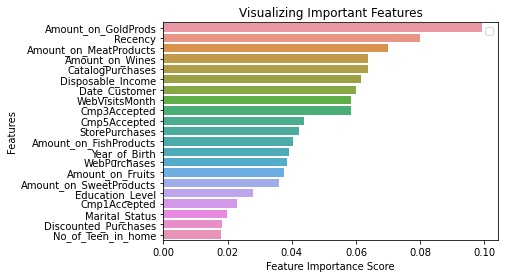

In [293]:
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [337]:

model_CBC = ctb.CatBoostClassifier()
model_CBC.fit(X_train,y_train)
expected_y  = y_test
predicted_y = model_CBC.predict(X_test)
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))

Learning rate set to 0.006831
0:	learn: 0.6901475	total: 962us	remaining: 962ms
1:	learn: 0.6868094	total: 2.83ms	remaining: 1.41s
2:	learn: 0.6845585	total: 4.65ms	remaining: 1.55s
3:	learn: 0.6811208	total: 6.56ms	remaining: 1.63s
4:	learn: 0.6784711	total: 8.37ms	remaining: 1.67s
5:	learn: 0.6750236	total: 10.1ms	remaining: 1.68s
6:	learn: 0.6723967	total: 12ms	remaining: 1.7s
7:	learn: 0.6692704	total: 13.8ms	remaining: 1.71s
8:	learn: 0.6659678	total: 15.6ms	remaining: 1.72s
9:	learn: 0.6632510	total: 17.5ms	remaining: 1.73s
10:	learn: 0.6603373	total: 19.3ms	remaining: 1.73s
11:	learn: 0.6578073	total: 20.3ms	remaining: 1.67s
12:	learn: 0.6555558	total: 22ms	remaining: 1.67s
13:	learn: 0.6535507	total: 23.8ms	remaining: 1.67s
14:	learn: 0.6511397	total: 25.6ms	remaining: 1.68s
15:	learn: 0.6494503	total: 27.3ms	remaining: 1.68s
16:	learn: 0.6461007	total: 34.2ms	remaining: 1.98s
17:	learn: 0.6439085	total: 36.4ms	remaining: 1.98s
18:	learn: 0.6414512	total: 38.4ms	remaining: 1.98

In [338]:
model_ltb = ltb.LGBMClassifier(random_state=1, learning_rate=0.12)
model_ltb.fit(X_train,y_train)
expected_y  = y_test
predicted_y = model_ltb.predict(X_test)
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84        48
           1       0.84      0.85      0.85        48

    accuracy                           0.84        96
   macro avg       0.84      0.84      0.84        96
weighted avg       0.84      0.84      0.84        96

[[40  8]
 [ 7 41]]


In [339]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train,y_train)
expected_y  = y_test
predicted_y = model_xgb.predict(X_test)
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        48
           1       0.83      0.83      0.83        48

    accuracy                           0.83        96
   macro avg       0.83      0.83      0.83        96
weighted avg       0.83      0.83      0.83        96

[[40  8]
 [ 8 40]]


In [340]:
model_gbc = GradientBoostingClassifier()
model_gbc.fit(X_train,y_train)
expected_y  = y_test
predicted_y = model_gbc.predict(X_test)
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))


              precision    recall  f1-score   support

           0       0.85      0.85      0.85        48
           1       0.85      0.85      0.85        48

    accuracy                           0.85        96
   macro avg       0.85      0.85      0.85        96
weighted avg       0.85      0.85      0.85        96

[[41  7]
 [ 7 41]]


In [341]:
model_abc = AdaBoostClassifier(base_estimator=model_CBC)
model_abc.fit(X_train,y_train)
expected_y  = y_test
predicted_y = model_abc.predict(X_test)
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))


Learning rate set to 0.006831
0:	learn: 0.6886659	total: 1.73ms	remaining: 1.73s
1:	learn: 0.6850091	total: 3.58ms	remaining: 1.78s
2:	learn: 0.6810040	total: 5.93ms	remaining: 1.97s
3:	learn: 0.6767253	total: 7.83ms	remaining: 1.95s
4:	learn: 0.6725622	total: 9.6ms	remaining: 1.91s
5:	learn: 0.6681535	total: 11.3ms	remaining: 1.88s
6:	learn: 0.6645166	total: 13.1ms	remaining: 1.86s
7:	learn: 0.6602253	total: 14.9ms	remaining: 1.85s
8:	learn: 0.6562724	total: 16.7ms	remaining: 1.84s
9:	learn: 0.6528309	total: 18.5ms	remaining: 1.83s
10:	learn: 0.6490280	total: 20.3ms	remaining: 1.82s
11:	learn: 0.6455284	total: 22ms	remaining: 1.81s
12:	learn: 0.6418436	total: 23.9ms	remaining: 1.81s
13:	learn: 0.6381247	total: 25.6ms	remaining: 1.8s
14:	learn: 0.6346911	total: 27.4ms	remaining: 1.8s
15:	learn: 0.6313520	total: 29.1ms	remaining: 1.79s
16:	learn: 0.6280233	total: 30.9ms	remaining: 1.78s
17:	learn: 0.6244269	total: 32.7ms	remaining: 1.78s
18:	learn: 0.6208297	total: 34.5ms	remaining: 1.7

In [342]:
model_bc = BaggingClassifier(base_estimator = model_rfc)
model_bc.fit(X_train,y_train)
expected_y  = y_test
predicted_y = model_bc.predict(X_test)
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))


              precision    recall  f1-score   support

           0       0.81      0.88      0.84        48
           1       0.86      0.79      0.83        48

    accuracy                           0.83        96
   macro avg       0.84      0.83      0.83        96
weighted avg       0.84      0.83      0.83        96

[[42  6]
 [10 38]]


In [343]:
model_dtc = DecisionTreeClassifier()
model_dtc.fit(X_train,y_train)
expected_y  = y_test
predicted_y = model_dtc.predict(X_test)
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))

              precision    recall  f1-score   support

           0       0.76      0.73      0.74        48
           1       0.74      0.77      0.76        48

    accuracy                           0.75        96
   macro avg       0.75      0.75      0.75        96
weighted avg       0.75      0.75      0.75        96

[[35 13]
 [11 37]]


In [344]:
model_etc = ExtraTreeClassifier()
model_etc.fit(X_train,y_train)
expected_y  = y_test
predicted_y = model_etc.predict(X_test)
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))

              precision    recall  f1-score   support

           0       0.74      0.81      0.77        48
           1       0.79      0.71      0.75        48

    accuracy                           0.76        96
   macro avg       0.76      0.76      0.76        96
weighted avg       0.76      0.76      0.76        96

[[39  9]
 [14 34]]


In [237]:
#Bagging Algorithm
# from yellowbrick.classifier import ROCAUC
mod = []
cv_score=[]
model =[model_gbc, model_CBC, model_xgb,model_ltb]
for m in model:
  cv_score.append(cross_val_score(m, X_train, y_train, scoring='f1', cv=5).mean())
  mod.append(m)
model_df=pd.DataFrame(columns=['model','cv_score'])
model_df['model']=mod
model_df['cv_score']=cv_score
model_df.sort_values(by=['cv_score'], ascending=True).style.background_gradient(subset=['cv_score'])

Streaming output truncated to the last 5000 lines.
4:	learn: 0.6802768	total: 8.3ms	remaining: 1.65s
5:	learn: 0.6773925	total: 10ms	remaining: 1.66s
6:	learn: 0.6747008	total: 11.7ms	remaining: 1.65s
7:	learn: 0.6720966	total: 13.3ms	remaining: 1.65s
8:	learn: 0.6694015	total: 14.9ms	remaining: 1.64s
9:	learn: 0.6668146	total: 16.6ms	remaining: 1.65s
10:	learn: 0.6644887	total: 18.3ms	remaining: 1.64s
11:	learn: 0.6622996	total: 19.2ms	remaining: 1.58s
12:	learn: 0.6602545	total: 20.8ms	remaining: 1.58s
13:	learn: 0.6584855	total: 22.5ms	remaining: 1.58s
14:	learn: 0.6560500	total: 24.2ms	remaining: 1.59s
15:	learn: 0.6542407	total: 25.9ms	remaining: 1.59s
16:	learn: 0.6514947	total: 27.5ms	remaining: 1.59s
17:	learn: 0.6495667	total: 29.4ms	remaining: 1.61s
18:	learn: 0.6474133	total: 31.2ms	remaining: 1.61s
19:	learn: 0.6447187	total: 32.8ms	remaining: 1.6s
20:	learn: 0.6429915	total: 34.4ms	remaining: 1.6s
21:	learn: 0.6407864	total: 36.1ms	remaining: 1.6s
22:	learn: 0.6389174	tota

,model,cv_score
0,"GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None, learning_rate=0.1, loss='deviance', max_depth=3, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='deprecated', random_state=None, subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)",0.788071
2,"XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3, min_child_weight=1, missing=None, n_estimators=100, n_jobs=1, nthread=None, objective='binary:logistic', random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=1, verbosity=1)",0.795913
3,"LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0, importance_type='split', learning_rate=0.12, max_depth=-1, min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31, objective=None, random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0, subsample_for_bin=200000, subsample_freq=0)",0.811826
1,,0.818152


In [ ]:
param={'n_estimators': [10,20,30,40,50,60,70,80,100,200,300,400,500,600,700]}
grid_Grd=GridSearchCV(model_bc, param_grid=param, cv=5, scoring='f1')
grid_Grd.fit(X_train, y_train)
print(f"Best Estimator: {grid_Grd.best_params_} , Best Score : {grid_Grd.best_score_}")


param={'n_estimators': [10,20,30,40,50,60,70,80,100,200,300,400,500,600,700]}
grid_Bag=GridSearchCV(model_abc, param_grid=param, cv=5, scoring='f1')
grid_Bag.fit(X_train, y_train)
print(f"Best Estimator: {grid_Bag.best_params_} , Best Score : {grid_Bag.best_score_}")

param={'n_estimators': [100,200,300,400,500,600,700]}
grid_Bag=GridSearchCV(model_gbc, param_grid=param, cv=5, scoring='f1')
grid_Bag.fit(X_train, y_train)
print(f"Best Estimator: {grid_Bag.best_params_} , Best Score : {grid_Bag.best_score_}")

param={'n_estimators': [100,200,300,400,500,600,700],'max_depth':[1,2,3,4,5,6,7,8,9,10]}
grid_Bag=GridSearchCV(model_xgb, param_grid=param, cv=5, scoring='f1')
grid_Bag.fit(X_train, y_train)
print(f"Best Estimator: {grid_Bag.best_params_} , Best Score : {grid_Bag.best_score_}")

param={'n_estimators': [100,200,300,400,500,600,700],}
grid_Bag=GridSearchCV(model_ltb, param_grid=param, cv=5, scoring='f1')
grid_Bag.fit(X_train, y_train)
print(f"Best Estimator: {grid_Bag.best_params_} , Best Score : {grid_Bag.best_score_}")

In [346]:
model_etc.fit(X_train,y_train)
val_pred1=model_etc.predict(X_test)
test_pred1=model_etc.predict(test)
val_pred1=pd.DataFrame(val_pred1)
test_pred1=pd.DataFrame(test_pred1)

model_dtc.fit(X_train,y_train)
val_pred2=model_dtc.predict(X_test)
test_pred2=model_dtc.predict(test)
val_pred2=pd.DataFrame(val_pred2)
test_pred2=pd.DataFrame(test_pred2)

model_bc.fit(X_train,y_train)
val_pred3=model_bc.predict(X_test)
test_pred3=model_bc.predict(test)
val_pred3=pd.DataFrame(val_pred3)
test_pred3=pd.DataFrame(test_pred3)

model_rfc.fit(X_train,y_train)
val_pred4=model_rfc.predict(X_test)
test_pred4=model_rfc.predict(test)
val_pred4=pd.DataFrame(val_pred4)
test_pred4=pd.DataFrame(test_pred4)

model_abc.fit(X_train, y_train)
val_pred5=model_abc.predict(X_test)
test_pred5=model_abc.predict(test)
val_pred5=pd.DataFrame(val_pred5)
test_pred5=pd.DataFrame(test_pred5)

model_ltb.fit(X_train,y_train)
val_pred6=model_ltb.predict(X_test)
test_pred6=model_ltb.predict(test)
val_pred6=pd.DataFrame(val_pred6)
test_pred6=pd.DataFrame(test_pred6)

model_xgb.fit(X_train,y_train)
val_pred7 =model_xgb.predict(X_test)
test_pred7=model_xgb.predict(test)
val_pred7=pd.DataFrame(val_pred7)
test_pred7=pd.DataFrame(test_pred7)

model_CBC.fit(X_train,y_train)
val_pred8=model_CBC.predict(X_test)
test_pred8=model_CBC.predict(test)
val_pred8=pd.DataFrame(val_pred8)
test_pred8=pd.DataFrame(test_pred8)

model_gbc.fit(X_train,y_train)
val_pred9=model_gbc.predict(X_test)
test_pred9=model_gbc.predict(test)
val_pred9=pd.DataFrame(val_pred9)
test_pred9=pd.DataFrame(test_pred9)


Stack = np.column_stack((val_pred1,val_pred2,val_pred3,val_pred4,val_pred5,val_pred6,val_pred7,val_pred8,val_pred9))
Stack_test= np.column_stack((test_pred1,test_pred2,test_pred3,test_pred4,test_pred5,test_pred6,test_pred7,test_pred8,test_pred9))
Stack
model = LogisticRegression()
model.fit(Stack,y_test)
#expected_y  = y_test
predicted_y = model.predict(Stack_test)
predicted_y

Learning rate set to 0.006831
0:	learn: 0.6886659	total: 1.78ms	remaining: 1.78s
1:	learn: 0.6850091	total: 3.6ms	remaining: 1.8s
2:	learn: 0.6810040	total: 5.36ms	remaining: 1.78s
3:	learn: 0.6767253	total: 7.16ms	remaining: 1.78s
4:	learn: 0.6725622	total: 8.89ms	remaining: 1.77s
5:	learn: 0.6681535	total: 12.3ms	remaining: 2.04s
6:	learn: 0.6645166	total: 14.2ms	remaining: 2.01s
7:	learn: 0.6602253	total: 16ms	remaining: 1.98s
8:	learn: 0.6562724	total: 17.9ms	remaining: 1.97s
9:	learn: 0.6528309	total: 20.2ms	remaining: 2s
10:	learn: 0.6490280	total: 22ms	remaining: 1.98s
11:	learn: 0.6455284	total: 23.8ms	remaining: 1.96s
12:	learn: 0.6418436	total: 25.6ms	remaining: 1.94s
13:	learn: 0.6381247	total: 27.4ms	remaining: 1.93s
14:	learn: 0.6346911	total: 29.2ms	remaining: 1.92s
15:	learn: 0.6313520	total: 31ms	remaining: 1.91s
16:	learn: 0.6280233	total: 32.8ms	remaining: 1.9s
17:	learn: 0.6244269	total: 34.6ms	remaining: 1.89s
18:	learn: 0.6208297	total: 36.3ms	remaining: 1.88s
19:	

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,

In [310]:
Stack

array([[0, 0, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]])

In [347]:
submission['Response'] = predicted_y
submission

,ID,Response
0,ID_ZPMABNVX,0
1,ID_WFE91NAA,0
2,ID_JV11RBRK,0
3,ID_6B7SVKY9,1
4,ID_GOVUZ545,1
...,...,...
667,ID_1D68PV28,0
668,ID_TM6CYFZO,0
669,ID_VHR666SC,0
670,ID_O852YAO1,0


In [348]:
submission.to_csv('SampleSubmission2.csv',index=False)

In [349]:
from google.colab import files
files.download('SampleSubmission2.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>